# **Final Project: Multinomial Naïve Bayes Model**
#### *By Carlos Santiago Bañón and Eduard Akhmetshin*
#### *CAP 6640, Spring '22*


## **1. Environment Setup**
---

In [1]:
import itertools
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import random
import re
import time
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, confusion_matrix, f1_score, precision_score, recall_score, make_scorer
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import label_binarize

In [2]:
# Seed the random number generators.
random.seed(42)
np.random.seed(42)

## **2. Data Preprocessing**
---

### **Load and Process the Dataset**

In [3]:
# Load the dataset into a Pandas DataFrame.
file_name = './data.csv'
df = pd.read_csv(file_name, sep='|', names=['overall', 'summary', 'review'], dtype={ 'overall':int, 'review':str })
df

,overall,summary,review
0,4,A solid overview of Dreamweaver CS5,I've been using Dreamweaver (and it's predeces...
1,4,A good value,"The demo is done with the PC version, with ref..."
2,5,This is excellent software for those who want ...,If you've been wanting to learn how to create ...
3,5,A Fantastic Overview of Dream Weaver and Web D...,I've been creating websites with Dreamweaver f...
4,5,Excellent Tutorials!,I decided (after trying a number of other prod...
...,...,...,...
10578,4,File Management Software with Basic Editing Ca...,When I ordered this it was listed as Photo Edi...
10579,3,"Might not be for the ""novice""",This software has SO much going on. Theres a p...
10580,4,"Great, Inexpensive Software for Those Who Have...",I have used both more complex and less complex...
10581,3,Gets the job done ... but not as easy as it sh...,Pinnacle Studio 20 Ultimate is a perfectly ser...


In [4]:
# Show the number of samples for each class.
df['overall'].value_counts()

5    4527
4    2761
3    1420
1    1241
2     634
Name: overall, dtype: int64

In [5]:
# Split the dataset into features and labels.
X = df['review'].to_numpy()
y = df['overall'].to_numpy() - 1

In [6]:
# Split the dataset into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **3. Multinomial Naïve Bayes Model**
---

### **Preprocess the Text**

In [7]:
# Download the stopwords from NLTK.
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/csbanon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
def text_preprocessing(s):
    """
    Process the text by performing the following:
    * Lowercase the sentence.
    * Change "'t" to "not".
    * Remove "@name".
    * Isolate and remove punctuations except "?".
    * Remove other special characters.
    * Remove stop words except "not" and "can".
    * Remove trailing whitespace.

    Based on the following tutorial given in class:
        https://skimai.com/fine-tuning-bert-for-sentiment-analysis/
    """

    # If needed, convert to string.
    s = str(s)

    # Lowercase the sentence.
    s = s.lower()

    # Change 't to 'not'.
    s = re.sub(r"\'t", " not", s)

    # Remove @name.
    s = re.sub(r'(@.*?)[\s]', ' ', s)

    # Isolate and remove punctuations except '?'.
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)

    # Remove some special characters.
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)

    # Remove stopwords except 'not' and 'can'.
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])

    # Remove trailing whitespace.
    s = re.sub(r'\s+', ' ', s).strip()

    return s

In [9]:
# Preprocess the text.
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_test_preprocessed = np.array([text_preprocessing(text) for text in X_test])

In [10]:
# Calculate the TF-IDF.
tf_idf = TfidfVectorizer(ngram_range=(1, 3))
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_test_tfidf = tf_idf.transform(X_test_preprocessed)

### **Train and Evaluate the Naïve Bayes Classifier**

#### **Train the Model**

In [11]:
# Train the model.
t0 = time.time()
nb_model = MultinomialNB(alpha=0.01)
nb_model.fit(X_train_tfidf, y_train)
t1 = time.time()
print("Training Time:", t1 - t0)

Training Time: 0.07093930244445801


#### **Evaluate the Model**

In [12]:
# Make predictions on the test set.
y_prob = nb_model.predict_proba(X_test_tfidf)
y_pred = np.argmax(y_prob, axis=1)

In [13]:
# Get the performance metrics.
print("Accuracy:", accuracy_score(y_pred, y_test))
print("Precision:", precision_score(y_pred, y_test, average='macro'))
print("Recall:", recall_score(y_pred, y_test, average='macro'))
print("F1 Score:", f1_score(y_pred, y_test, average='macro'))

Accuracy: 0.5063769485120454
Precision: 0.34501790814478256
Recall: 0.5469890674543942
F1 Score: 0.3482280743429341


In [14]:
def confusion_matrix_plot(y_test, y_pred, title='Confusion Matrix'):
    """
    Plot a confusion matrix given the test and predicted labels.
    """
    
    # Compute the confusion matrix.
    classes = [0, 1, 2, 3, 4]
    matrix = confusion_matrix(y_test, y_pred, labels=classes)
    
    # Plot the confusion matrix.
    plt.figure()
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Reds)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    labels = [1, 2, 3, 4, 5]
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    # Define a color threshold.
    threshold = matrix.max() / 2.0
    
    # Show the values.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        
        if matrix[i, j] > threshold:
            color = "white"
        else:
            color = "black"
            
        plt.text(j, i, format(matrix[i, j], 'd'), horizontalalignment="center", color=color)

    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.tight_layout()

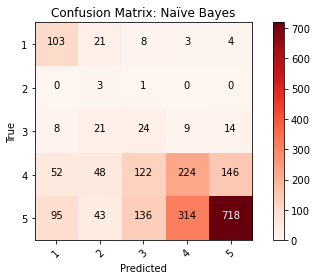

In [15]:
confusion_matrix_plot(y_pred, y_test, title="Confusion Matrix: Naïve Bayes")

In [16]:
def roc_plot(y_prob, y_pred, y, title='ROC'):
    """
    Plot the ROC curve given the true and predicted labels.
    """
        
    num_classes = y_prob.shape[1]
    auc_list = []    
    
    # Binarize the labels.
    classes = [0, 1, 2, 3, 4]
    y_pred_binary = label_binarize(y_pred, classes=classes)
    y_binary = label_binarize(y, classes=classes)
    
    # Compute the AUC for each class.
    for i in range(num_classes):

        y_pred_i = y_prob[:, i]
        y_i = y_binary[:, i]

        # Compute the AUC.
        fpr, tpr, threshold = roc_curve(y_i, y_pred_i)
        roc_auc = auc(fpr, tpr)
        auc_list.append(roc_auc)

        # Plot the AUC.
        plt.plot(fpr, tpr, label=f'AUC ({i+1}-Star): {roc_auc:.4f}')

    # Configure the ROC curve.
    plt.title(title)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    return np.mean(auc_list)

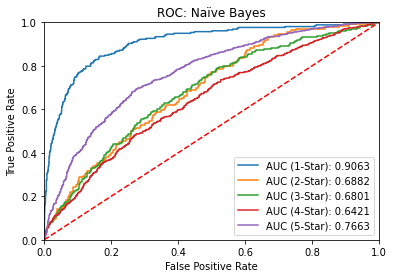

Avg. AUC: 0.7366085315965225


In [17]:
# Plot the ROC.
avg_auc = roc_plot(y_prob, y_pred, y_test, "ROC: Naïve Bayes")
print("Avg. AUC:", avg_auc)

In [18]:
def off_by_one_accuracy_score(y_pred, y):
    """
    Compute the Off-by-One accuracy given the true and predicted labels.
    """
    
    num_samples = len(y_pred)
    accurate_preds = []
    
    for i in range(num_samples):
        val = np.abs(y_pred[i] - y[i])
        accurate_preds.append(1 if val <= 1 else 0)
        
    return np.mean(accurate_preds)

In [19]:
# Compute the off-by-one accuracy.
off_by_one_acc = off_by_one_accuracy_score(y_pred, y_test)
print("Off-by-One Accuracy:", off_by_one_acc)

Off-by-One Accuracy: 0.8058573452999528
